In [16]:
#try to forecast sales in the area's of the data base 


In [17]:
import pandas as pd
#i will use weekly for aesthetic reasons, daily is unreadable
#get a new data set for arima where we have week and collumn for sales
data = pd.read_csv('car_data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data['Week'] = data['Date'].dt.isocalendar().week
weekly_sales = data.groupby('Week').size().reset_index(name='Sales')
data
#display the result
weekly_sales


,Week,Sales
0,1,205
1,2,155
2,3,190
3,4,110
4,5,300
5,6,120
6,7,225
7,8,150
8,9,305
9,10,360


,Sales
1,205
2,155
3,190
4,110
5,300
6,120
7,225
8,150
9,305
10,360


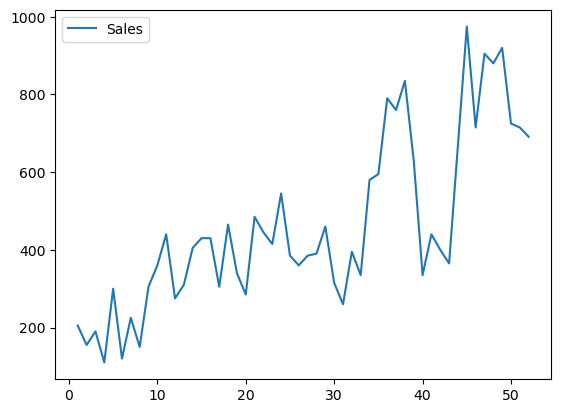

In [18]:
#drops weeks from data
ws = weekly_sales.drop('Week', axis=1).reset_index(drop=True)
ws.index += 1

# Display the adjusted DataFrame
ws.plot()
ws


<Axes: >

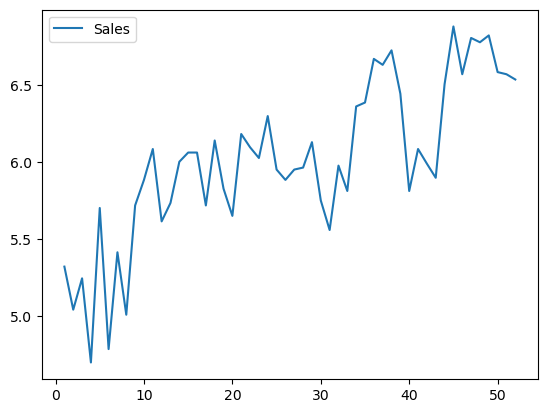

In [19]:
import numpy as np
#stabilize variants
ws = np.log(ws) # dont forget to transform data back when making real predicitions
ws.plot()

In [20]:
#predict next month + week
msk = (ws.index< len(ws)-5)
#split into training and test sets
ws_train = ws[msk].copy()
ws_test = ws[~msk].copy()

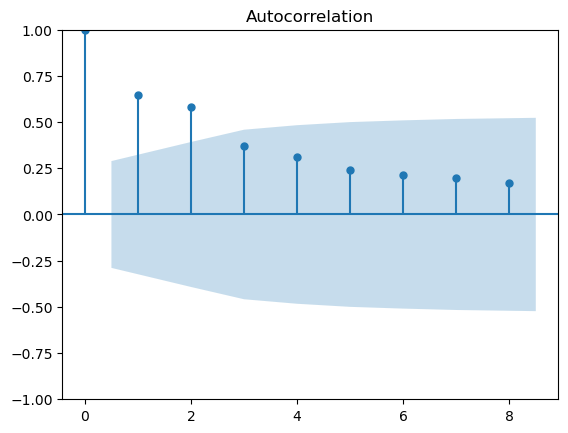

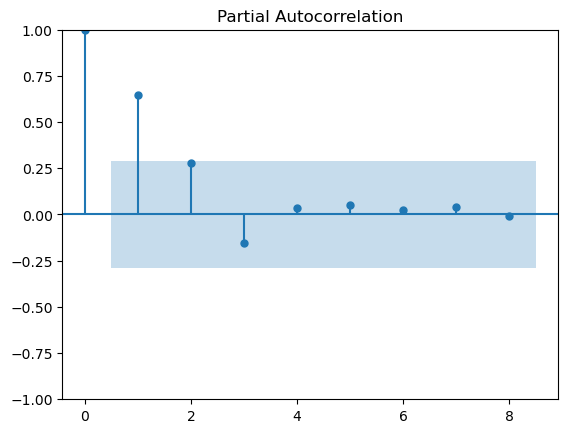

In [21]:
#acf plot and pacf plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Manually set the nlags to a value less than 9
nlags_pacf = min(len(ws_train) // 2 - 1, 8)  # Ensuring nlags is less than 9

# Plot ACF and PACF with the appropriate number of lags
acf_original = plot_acf(ws_train, lags=nlags_pacf)
pacf_original = plot_pacf(ws_train, lags=nlags_pacf)

In [22]:
#adf test
#non stationary 
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(ws_train)
print(f'p-value: {adf_test[1]}')

p-value: 0.0507497587588054


<Axes: >

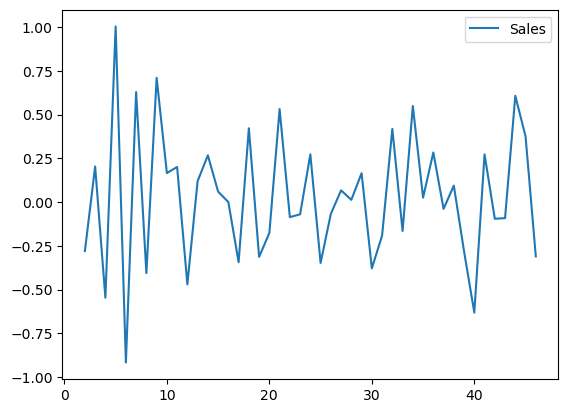

In [23]:
#transform to stationary:differencing
ws_train_diff = ws_train.diff().dropna()
ws_train_diff.plot()

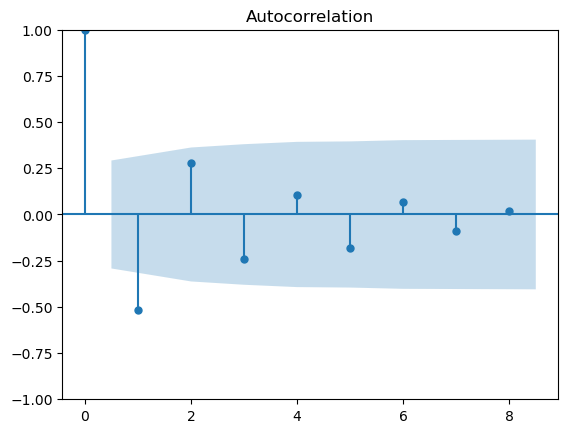

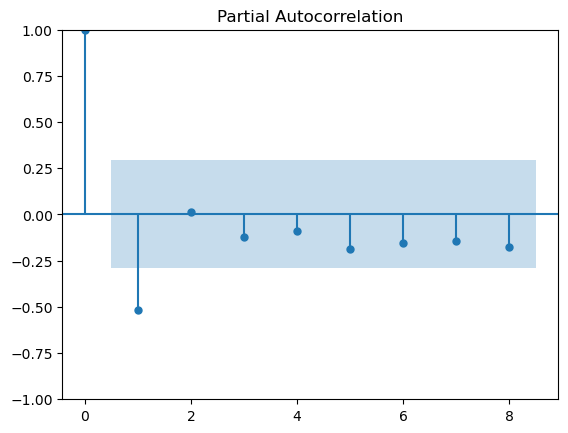

In [24]:
acf_dff = plot_acf(ws_train_diff, lags=nlags_pacf)

pacf_diff = plot_pacf(ws_train_diff, lags=nlags_pacf)

In [25]:
adf_test = adfuller(ws_train_diff)
print(f'p-value: {adf_test[1]}')

p-value: 2.118059450332117e-21


In [26]:
#d=1
# 110
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(ws_train, order=(1,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   46
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -13.908
Date:                Tue, 07 May 2024   AIC                             31.816
Time:                        11:14:21   BIC                             35.429
Sample:                             0   HQIC                            33.163
                                 - 46                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5104      0.115     -4.443      0.000      -0.736      -0.285
sigma2         0.1079      0.025      4.298      0.000       0.059       0.157
Ljung-Box (L1) (Q):                   0.00   Jarque-

c:\Users\Korisnik\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Korisnik\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Korisnik\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


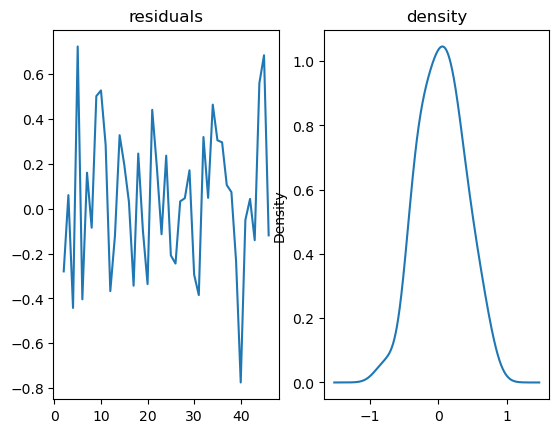

In [27]:
#make prediction
import matplotlib.pyplot as plt
residuals= model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='residuals', ax=ax[0])
residuals.plot(title='density', kind='kde', ax=ax[1])
plt.show()

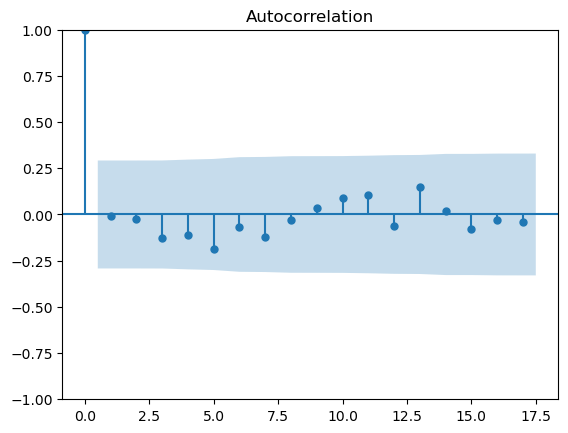

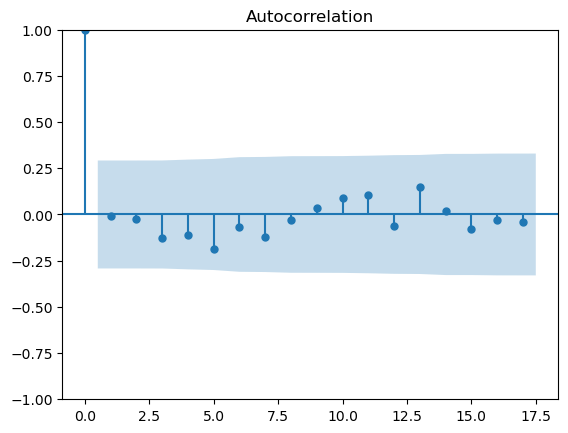

In [28]:
acf_res = plot_acf(residuals)
pacf_res = plot_acf(residuals)

c:\Users\Korisnik\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Korisnik\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<Axes: >

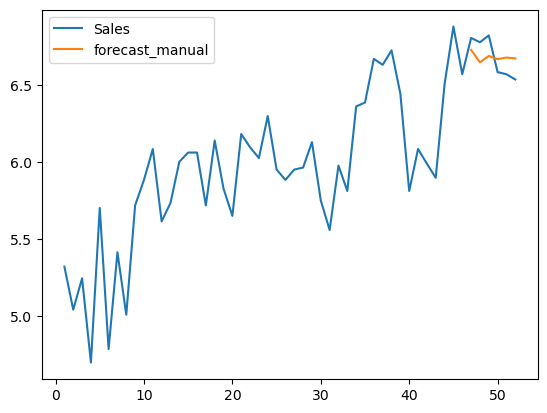

In [29]:
forecast_test = model_fit.forecast(len(ws_test))
ws['forecast_manual'] = [None]*len(ws_train) + list(forecast_test)
ws.plot()